In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras import optimizers
import pickle
from utils import *

In [3]:
def pad_seq_data(seq_data, pad_val=-1, max_len=None):
    if max_len is None:
        lens = np.array([len(seq) for seq in seq_data])
        max_len = np.max(lens)
    new_seq = []
    for i in range(len(seq_data)):
        pad_len = max_len - len(seq_data[i])
        if pad_len > 0:
            padding = np.array(
                [[pad_val for _ in range(len(seq_data[0][0]))] for _ in range(pad_len)]
            )
            # print(s.shape, padding.shape)
            seq_data[i] = np.concatenate([seq_data[i], padding],
                                         axis=0).tolist()
        elif pad_len < 0:
            seq_data[i] = list(seq_data[i][:max_len])
        new_seq.append(seq_data[i])
    return np.array(new_seq)

# Pipeline:

* take protein sequences of positive linear data
* predict possible candidates
* put through predictive model

## Train sequence model

In [19]:
with open("seq_model_data", "rb") as infile:
    (data_seq, labels_seq, ids) = pickle.load(infile)

In [20]:
x_train_seq, y_train_seq, x_val_seq, y_val_seq, x_test_seq, y_test_seq = get_train_test_linear(data_seq, labels_seq, 0.8, 0.1, 0.1)

number of protein sequences: 195437 24429 24431
train: (195437, 9, 34) (195437,) val: (24431, 9, 34) (24431,) test: (24429, 9, 34) (24429,)


In [74]:
include_feats_list = np.arange(5, 13, 1) # all continoous features # np.arange(0,5,1) #
WIN_SIZE=9
N_FEATS = len(include_feats_list)

In [75]:
x_train_in = (x_train_seq[:,:,include_feats_list]).reshape(len(x_train_seq), WIN_SIZE*N_FEATS)
x_val_in = (x_val_seq[:,:,include_feats_list]).reshape(len(x_val_seq), WIN_SIZE*N_FEATS)

In [76]:
clf = RandomForestRegressor(max_depth=10)
clf.fit(x_train_in, y_train_seq)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [77]:
# for RF regressor
out = clf.predict(x_val_in)
print("accuracy:", accuracy_score(y_val_seq, out>0.5), "balanced:", balanced_accuracy_score(y_val_seq, out>0.5))
print("roc auc:", roc_auc_score(y_val_seq, out)) # [:,1]

accuracy: 0.6567885064057959 balanced: 0.5030397454708115
roc auc: 0.5550658020860106


In [45]:
# for RF classifier: 
out = clf.predict_proba(x_val_in)
print("accuracy:", accuracy_score(y_val_seq, out[:,1]>0.5), "balanced:", balanced_accuracy_score(y_val_seq, out[:,1]>0.5))
print("roc auc:", roc_auc_score(y_val_seq, out[:,1])) # [:,1]

accuracy: 0.6564610535794687 balanced: 0.5015473374311555
roc auc: 0.556436899369815


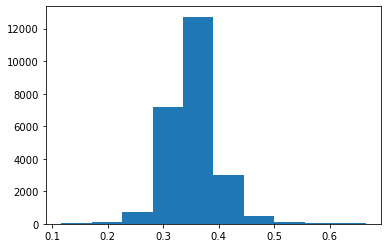

In [71]:
plt.hist(out)
plt.show()

## Convert into candidates of epitopes

In [127]:
with open("protein_seq_data", "rb") as infile:
    (test_seq, ids) = pickle.load(infile) # test_labels_seq,

In [128]:
test_seq.shape, ids.shape # , test_labels_seq.shape 

((453897, 9, 34), (453897,))

In [129]:
test_seq_in = (test_seq[:,:,include_feats_list]).reshape(len(test_seq), WIN_SIZE*N_FEATS)

In [130]:
# test with other sequences of the linear data set
_, counts = np.unique(ids, return_counts=True) # counts are lengths of the respective sequences
EPI_LEN = MAX_SEQ_LEN # 15 # to avoid padding below!
N_MAX = 3

In [131]:
test_preds = clf.predict(test_seq_in)

In [132]:
from scipy.signal import find_peaks 
def find_maxima(signal, n_vals=5):
    maxima = find_peaks(signal, distance=20)[0]
    # plt.plot(signal)
    # plt.scatter(maxima, signal[maxima])
    vals = signal[maxima]
    args = np.argsort(vals)[-n_vals:]
    # plt.scatter(maxima[args], signal[maxima[args]])
    # plt.show()
    return maxima[args]

In [133]:
cum_count = 0
smooth_filter = [1 for _ in range(EPI_LEN)]

candidates_per_sequ = []

for c in counts:
    sequ_out = test_preds[cum_count:cum_count+c]
    smoothed_sequ = (np.convolve(sequ_out, smooth_filter) / EPI_LEN)[EPI_LEN//2:-EPI_LEN//2]
    
    # best_ids = np.argsort(smoothed_sequ)[-N_MAX:]
    best_ids = find_maxima(np.array(smoothed_sequ), N_MAX)
    
    # actual features
    test_feat_arr = test_seq[cum_count:cum_count+c]
    
    candidates = []
    for b in best_ids:
        low = max([b-EPI_LEN//2, 0])
        high = min([b+EPI_LEN//2, len(test_feat_arr)])
        
        candidates.append(test_feat_arr[low:high, WIN_SIZE//2])
    
    candidates_per_sequ.append(candidates)
    
    # TESTING
    gt = test_labels_seq[cum_count:cum_count+c]
    
    # print(best_ids)
    # print(len(smoothed_sequ), len(sequ_out))
    # plt.figure(figsize=(20,10))
    # plt.plot(gt, label="gt")
    # plt.plot(smoothed_sequ, label="smooth")
    # plt.plot(sequ_out, label="preds")
    # plt.scatter(best_ids, sequ_out[best_ids])
    # plt.legend()
    # plt.show()
    
    cum_count += c

## Train predictive model

In [4]:
## old version
# linear_df = pd.read_csv("data/linear_data_seq.csv")
# data = np.array([eval(d) for d in linear_df["data"]])
# labels = linear_df["labels"].values

with open("pred_model_data", "rb") as infile:
    data, labels = pickle.load(infile)

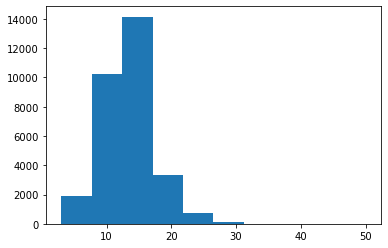

In [5]:
lens = np.array([len(d) for d in data])
plt.hist(lens)
plt.show()

In [6]:
MAX_SEQ_LEN = 30
N_FEATURES = 34
# padding and trim to max length
data = pad_seq_data(data, max_len=MAX_SEQ_LEN, pad_val=-2)
print(data.shape, len(labels))
# normalize
data = (data-np.min(data))/ (np.max(data)-np.min(data))

(30556, 30, 34) 30556


### Balance

In [7]:
_, c = np.unique(labels, return_counts=True)
cutoff = 2 * c[1]
labels = labels[:cutoff]
data = data[:cutoff]

### Construct train and test set

In [8]:
def get_train_test_linear(data, labels, train_size, test_size, val_size):
    # first select train and test samples
    inds = np.random.permutation(len(data))
    train_inds = inds[:int(train_size*len(inds))]
    test_inds = inds[int(train_size*len(inds)): int(train_size*len(inds))+int(test_size*len(inds))]
    val_inds = inds[int(train_size*len(inds))+int(test_size*len(inds)):]
    
    x_train = data[train_inds]
    y_train = labels[train_inds]
    x_test = data[test_inds]
    y_test = labels[test_inds]
    x_val = data[val_inds]
    y_val = labels[val_inds]

    print("number of protein sequences:", len(train_inds), len(test_inds), len(val_inds))
    print("train:", x_train.shape, y_train.shape,"val:", x_val.shape, y_val.shape, "test:", x_test.shape, y_test.shape)
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = get_train_test_linear(data, np.array(labels), 0.8, 0.1, 0.1)

number of protein sequences: 18934 2366 2368
train: (18934, 30, 34) (18934,) val: (2368, 30, 34) (2368,) test: (2366, 30, 34) (2366,)


### Train model

In [35]:
# START CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(MAX_SEQ_LEN,N_FEATURES)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(Dropout(0.2))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(56, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [37]:
# train model
epochs = 40
batch_size = 64
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size) # , class_weight=class_weight)

Train on 18934 samples, validate on 2368 samples
Epoch 1/40
18934/18934 [==============================] - 4s 185us/sample - loss: 0.2407 - acc: 0.5908 - val_loss: 0.2330 - val_acc: 0.6305
Epoch 2/40
18934/18934 [==============================] - 3s 179us/sample - loss: 0.2282 - acc: 0.6217 - val_loss: 0.2255 - val_acc: 0.6334
Epoch 3/40
18934/18934 [==============================] - 4s 216us/sample - loss: 0.2212 - acc: 0.6425 - val_loss: 0.2179 - val_acc: 0.6651
Epoch 4/40
18934/18934 [==============================] - 3s 154us/sample - loss: 0.2168 - acc: 0.6583 - val_loss: 0.2167 - val_acc: 0.6639
Epoch 5/40
18934/18934 [==============================] - 3s 153us/sample - loss: 0.2144 - acc: 0.6653 - val_loss: 0.2108 - val_acc: 0.6867
Epoch 6/40
18934/18934 [==============================] - 3s 160us/sample - loss: 0.2130 - acc: 0.6662 - val_loss: 0.2101 - val_acc: 0.6812
Epoch 7/40
18934/18934 [==============================] - 3s 177us/sample - loss: 0.2121 - acc: 0.6713 - val_lo

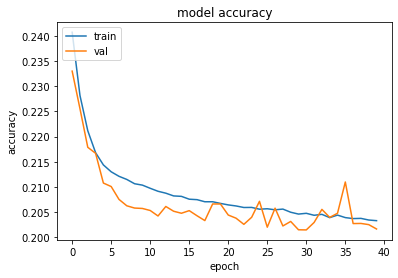

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
# evaluate
_, accuracy = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("accuracy", accuracy)
out = model.predict(x_val)
print("roc auc:", roc_auc_score(y_val, out))

print("acc 1 labels", accuracy_score(y_val[y_val==1], (out[y_val==1]>0.5).astype(int)))
print("acc 0 labels", accuracy_score(y_val[y_val==0], (out[y_val==0]>0.5).astype(int)))

accuracy 0.6993243
roc auc: 0.753378375965263
acc 1 labels 0.6029798422436459
acc 0 labels 0.7889160554197229


### Results:

**40 epochs, 64 batch size, balanced data (less negatives), max len 30**

* accuracy 0.6651182
* roc auc: 0.7301934192229126
* acc 1 labels 0.6627810158201499
* acc 0 labels 0.6675235646958012

### Predict SARS epitopes

In [41]:
with open("epi_sars_data", "rb") as outfile:
    epi_sars = pickle.load(outfile)

In [42]:
print(len(epis_sars))
epis_sars_data = pad_seq_data(epi_sars, max_len=MAX_SEQ_LEN, pad_val=-2)
norm_epis_sars_data = (epis_sars_data-np.min(epis_sars_data))/(np.max(epis_sars_data)-np.min(epis_sars_data))

299


In [43]:
out_sars = model.predict(norm_epis_sars_data)

accuracy: 0.7993311036789298


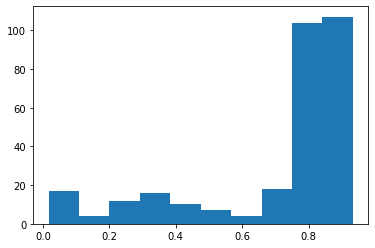

In [44]:
gt_epi_labels = [1 for _ in range(len(epis_sars))]
print("accuracy:", accuracy_score(gt_epi_labels, (out_sars>0.5).astype(int)))
plt.hist(out_sars)
plt.show()

### Refine model with SARS epitopes

In [25]:
model.fit(norm_epis_sars_data, gt_epi_labels)

299/299 [==============================] - 0s 238us/sample - loss: 0.0912 - acc: 0.8796


## Predict for test_seq_data

In [134]:
cands_concat = []
for can in candidates_per_sequ:
    for c in can:
        cands_concat.append(c)

In [135]:
MAX_SEQ_LEN = 30
N_FEATURES = 34
# padding and trim to max length
test_data = pad_seq_data(cands_concat, max_len=MAX_SEQ_LEN, pad_val=-2)
print(test_data.shape)
# normalize
test_data = (test_data-np.min(test_data))/ (np.max(test_data)-np.min(test_data))

(1296, 30, 34)


In [136]:
out_test_seq = model.predict(test_data)

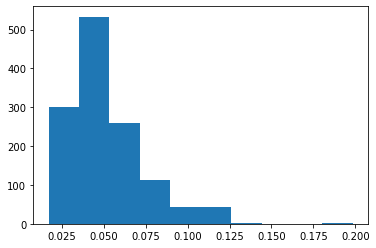

In [137]:
# almost all zero --> was in training data!
plt.hist(out_test_seq)
plt.show()